<a href="https://colab.research.google.com/github/ElizabethEwurabena/CV_ENG_8160/blob/main/HOMEWORK_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/CV_ENG_8160/module 3'

/content/drive/MyDrive/CV_ENG_8160/module 3


In [3]:
## get_item works only for localization
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from PIL import Image
import cv2
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [4]:
class CustomDataloader(Dataset):
    def __init__(self, local_dir, cls_dir, task_type=None, class_name=None, transform=None):
        self.task_type = task_type
        self.transform = transform
        self.local_dir = local_dir
        self.cls_dir = cls_dir
        # Read CSV files
        self.local_labels_df = pd.read_csv(os.path.join(local_dir, 'train.csv'))
        self.cls_labels_df = pd.read_csv(os.path.join(cls_dir, 'train.csv'))
        # Prepend zeros to filenames in the CSV files
        self.local_labels_df['img_name'] = self.local_labels_df['img_name'].apply(lambda x: str(x).zfill(8))
        self.cls_labels_df['img_name'] = self.cls_labels_df['img_name'].apply(lambda x: str(x).zfill(8))
        self.local_imgs = os.path.join(local_dir, 'classd')
        self.cls_imgs = os.path.join(cls_dir, 'data')
        self.cls_img_classes = os.listdir(self.cls_imgs)
        self.class_name = class_name

    def __len__(self):
        if self.task_type == "classification":
            return len(self.cls_labels_df)
        elif self.task_type == "localization":
            return len(self.local_labels_df)

    def __getitem__(self, idx):
        if self.task_type == "classification":
            image = None
            label = None
            img_name = str(self.cls_labels_df.iloc[idx, 0]) + '.jpg'
            label = self.cls_labels_df.iloc[idx, 1]
            for class_name in self.cls_img_classes:
                class_img_folder = os.path.join(self.cls_imgs, class_name)
                for filename in os.listdir(class_img_folder):
                    if filename == img_name:
                        img_path = os.path.join(class_img_folder, filename)
                        image = io.imread(img_path)
                        break
                if image is not None:
                    break
            if image is None:
                raise FileNotFoundError(f"Image with index {idx} not found in any class folder")
            sample = {'image': image, 'label': label}

        elif self.task_type == "localization":
            img_name = str(self.local_labels_df.iloc[idx, 0]) + '.jpg'
            img_path = os.path.join(self.local_imgs, img_name)
            image = io.imread(img_path)
            label = self.local_labels_df.iloc[idx, 1]
            file_name = self.local_labels_df.iloc[idx, 0]
            file_rows = self.local_labels_df[self.local_labels_df.iloc[:, 0] == file_name]
            bb=[]
            for _, row in file_rows.iterrows():
                x, y, w, h = row[2:]
                x, y, w, h = int(x), int(y), int(w), int(h)
                bb.append([x, y, w, h])

            sample = {'image': image, 'label': label, 'bounding_boxes': bb}

        if self.transform:
            sample = self.transform(sample)

        return sample


class Rescale(object):
    def __init__(self, output_size, task_type=None): #use int
       assert isinstance(output_size, (int, tuple))
       self.output_size = output_size
       self.task_type = task_type

    def __call__(self, sample):
       image, label = sample['image'], sample['label']
       h, w = image.shape[:2]
       if isinstance(self.output_size, int):
           if h > w:
               new_h, new_w = self.output_size * h / w, self.output_size
           else:
               new_h, new_w = self.output_size, self.output_size * w / h
       else:
           new_h, new_w = self.output_size
       new_h, new_w = int(new_h), int(new_w)
       img = transform.resize(image, (new_h, new_w))

       if self.task_type == "classification":
          return {'image': img, 'label': label}

       elif self.task_type == "localization":
          bounding_boxes = sample['bounding_boxes']
          transformed_boxes = []
          # Scale bounding box coordinates
          x_scale = new_w / w
          y_scale = new_h / h

          for box in bounding_boxes:
              x, y, bbw, bbh = box
              # Scale box coordinates
              new_x = int(x * x_scale)
              new_y = int(y * y_scale)
              new_bbw = int(bbw * x_scale)
              new_bbh = int(bbh * y_scale)
              transformed_boxes.append([new_x, new_y, new_bbw, new_bbh])

          sample['bounding_boxes'] = transformed_boxes
          return {'image': img, 'label': label, 'bounding_boxes': transformed_boxes}


class Flip(object):
    def __init__(self, flip_type, task_type=None):
       assert flip_type in [0, 1]
       self.flip_type = flip_type
       self.task_type = task_type

    def __call__(self, sample):
       image, label = sample['image'], sample['label']
       if self.flip_type == 1:
          image = np.flip(image, axis=0).copy() # Vertical flip
       elif self.flip_type == 0:
          image = np.flip(image, axis=1).copy() # Horizontal flip

       if self.task_type == "classification":
          return {'image': image, 'label': label}

       elif self.task_type == "localization":
          bounding_boxes = sample['bounding_boxes']
          transformed_boxes = []
          height, width = image.shape[:2]
          for box in bounding_boxes:
              x, y, w, h = box
              if self.flip_type == 0:  # Horizontal flip
                  new_x = width - x
                  new_w=width-w
                  transformed_boxes.append([new_x, y, new_w, h])
              elif self.flip_type == 1:
                  new_y = height - y # Vertical flip
                  new_h = height - h
                  transformed_boxes.append([x,new_y, w, new_h])
          sample['bounding_boxes'] = transformed_boxes
          return {'image': image, 'label': label, 'bounding_boxes': transformed_boxes}


class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        print(type(image))
        image = torch.from_numpy(image)
        imageT = image.transpose(1,2).transpose(0,1)
        print(image.shape, imageT.shape)
        return {'image': imageT, 'label': label}

class Normalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).unsqueeze(1).unsqueeze(1)
        self.std = torch.tensor(std).unsqueeze(1).unsqueeze(1)

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        norm_img = (image - self.mean) / self.std
        return {'image': norm_img, 'label': label}


def cls_visualize(cls_data):
  fig = plt.figure(figsize=(20, 20))
  ncols = 3
  for i, sample in enumerate(cls_data):
      print(i, sample['image'].shape, sample['label'])
      transformed_sample = compose_transforms(sample)
      ax = plt.subplot(1, ncols, i + 1)
      plt.tight_layout()
      ax.set_title('Sample #{} - {}'.format(i, sample['label']))
      plt.imshow(transformed_sample['image'])

      if i == ncols - 1:
          plt.show()
          break
def local_visualize(cls_data):
  fig = plt.figure(figsize=(20, 20))
  ncols = 3
  for i, sample in enumerate(cls_data):
      transformed_sample = compose_transforms(sample)
      print("Bounding Boxes:", transformed_sample.get('bounding_boxes', None))
      ax = plt.subplot(1, ncols, i + 1)
      plt.tight_layout()
      ax.set_title('Sample #{} - {}'.format(i, transformed_sample['label']))
      if 'bounding_boxes' in transformed_sample:  # Check if bounding boxes exist
        for box in transformed_sample['bounding_boxes']:
          x, y, w, h = box
          img=cv2.rectangle(transformed_sample['image'], (x, y), (w, h), (255, 0, 0), 2)
          plt.imshow(transformed_sample['image'])
      if i == ncols - 1:
          plt.show()
          break


**CLASSIFICATION**

0 (274, 383, 3) single_unit_truck
1 (68, 98, 3) single_unit_truck
2 (78, 80, 3) single_unit_truck


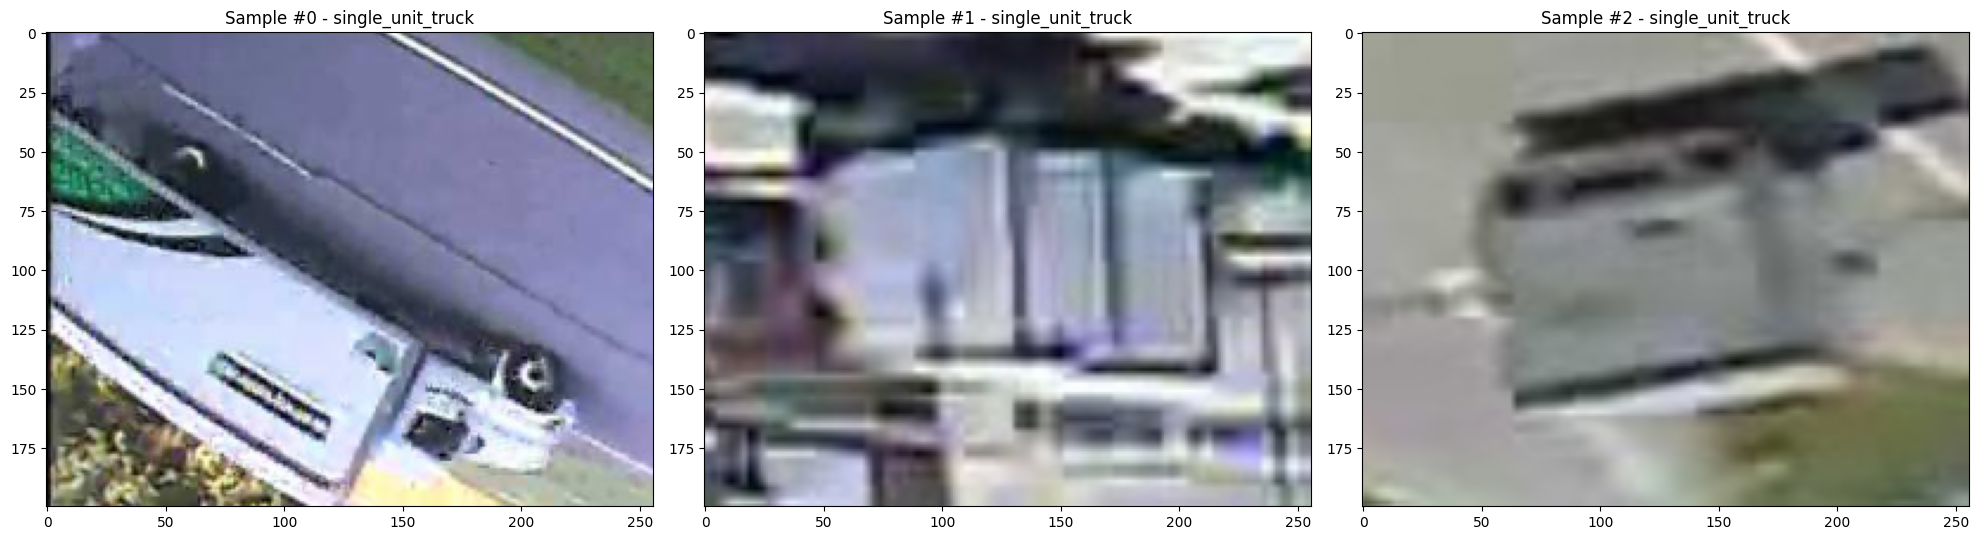

In [5]:
local_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/localize'
cls_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/classification'

task_type = "classification"
class_name='work_van'
compose_transforms = transforms.Compose([Rescale(output_size=(200, 256), task_type = "classification"),
                                         Flip(flip_type=1, task_type = "classification")
                                         ])
cls_data = CustomDataloader(local_dir, cls_dir, task_type, class_name)
cls_visualize(cls_data)

0 (274, 383, 3) single_unit_truck
1 (68, 98, 3) single_unit_truck
2 (78, 80, 3) single_unit_truck


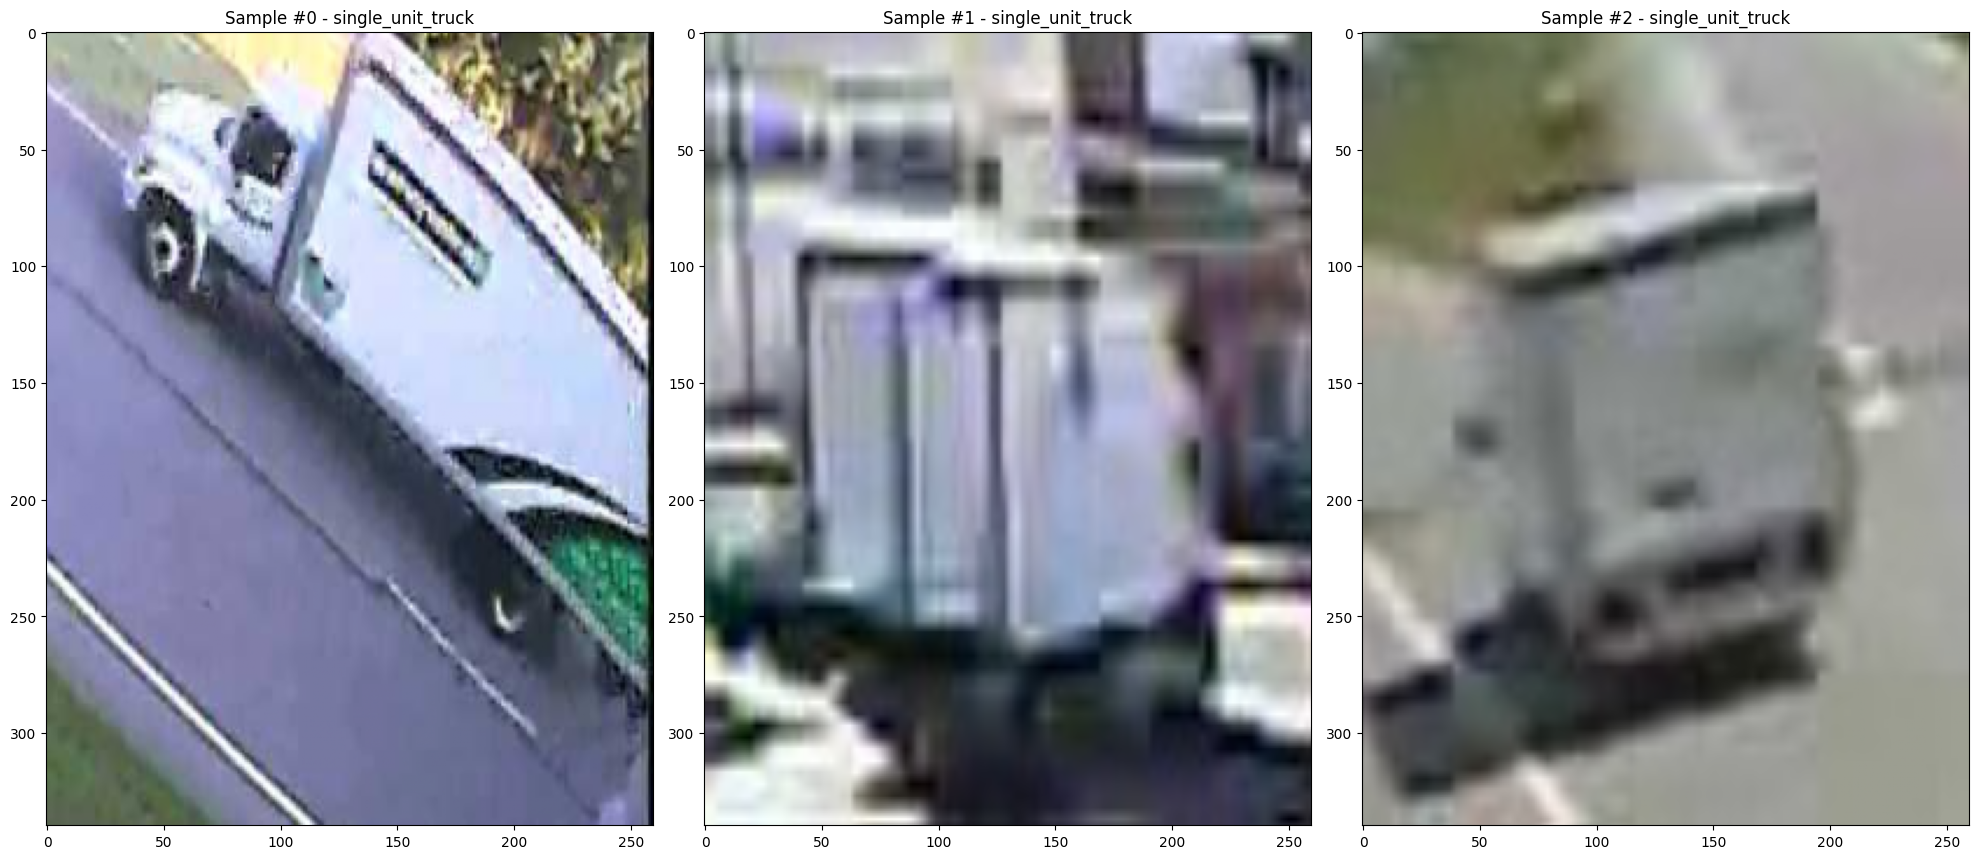

In [6]:
local_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/localize'
cls_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/classification'

task_type = "classification"
class_name='work_van'

compose_transforms = transforms.Compose([Rescale(output_size=(340, 260), task_type = "classification"),
                                         Flip(flip_type=0,task_type = "classification")
                                         ])

cls_data = CustomDataloader(local_dir, cls_dir, task_type, class_name)
cls_visualize(cls_data)

In [7]:
#convert to pytorch tensor
local_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/localize'
cls_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/classification'

task_type = "classification"
class_name='work_van'
compose_transforms = transforms.Compose([Rescale(output_size=(200, 256), task_type = "classification"),
                                         Flip(flip_type=0,task_type = "classification"),
                                         ToTensor(),
                                        #  Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
                                        ])

cls_data = CustomDataloader(local_dir, cls_dir, task_type, class_name, transform=compose_transforms)
selected_cls_image = cls_data[31]
selected_cls_image

<class 'numpy.ndarray'>
torch.Size([200, 256, 3]) torch.Size([3, 200, 256])


{'image': tensor([[[0.9513, 0.9443, 0.9317,  ..., 0.3258, 0.3231, 0.3221],
          [0.9497, 0.9442, 0.9351,  ..., 0.3258, 0.3216, 0.3198],
          [0.9571, 0.9449, 0.9199,  ..., 0.3259, 0.3285, 0.3299],
          ...,
          [0.7647, 0.7686, 0.7770,  ..., 0.6629, 0.6381, 0.6295],
          [0.7726, 0.7730, 0.7742,  ..., 0.6337, 0.6061, 0.5966],
          [0.7709, 0.7721, 0.7748,  ..., 0.6402, 0.6132, 0.6039]],
 
         [[0.9239, 0.9169, 0.9050,  ..., 0.3768, 0.3741, 0.3730],
          [0.9222, 0.9167, 0.9083,  ..., 0.3768, 0.3726, 0.3708],
          [0.9296, 0.9175, 0.8932,  ..., 0.3769, 0.3795, 0.3809],
          ...,
          [0.7686, 0.7725, 0.7812,  ..., 0.6747, 0.6498, 0.6412],
          [0.7766, 0.7770, 0.7783,  ..., 0.6454, 0.6178, 0.6084],
          [0.7748, 0.7760, 0.7790,  ..., 0.6519, 0.6249, 0.6157]],
 
         [[0.9840, 0.9778, 0.9656,  ..., 0.4077, 0.4055, 0.4044],
          [0.9833, 0.9783, 0.9688,  ..., 0.4076, 0.4039, 0.4022],
          [0.9864, 0.9761, 0.95

In [8]:
local_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/localize'
cls_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/classification'

task_type = "classification"
class_name='work_van'
compose_transforms = transforms.Compose([Rescale(output_size=(200, 256), task_type = "classification"),
                                         Flip(flip_type=0,task_type = "classification"),
                                         ToTensor(),
                                        #  Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
                                        Normalize(mean=torch.Tensor([0.5, 0.5, 0.5]),std=torch.Tensor([0.5, 0.5, 0.5]))
                                        ])

cls_data = CustomDataloader(local_dir, cls_dir, task_type, class_name, transform=compose_transforms)
selected_cls_image = cls_data[31]
selected_cls_image

<class 'numpy.ndarray'>
torch.Size([200, 256, 3]) torch.Size([3, 200, 256])


{'image': tensor([[[ 0.9027,  0.8887,  0.8634,  ..., -0.3484, -0.3538, -0.3559],
          [ 0.8994,  0.8883,  0.8701,  ..., -0.3484, -0.3569, -0.3603],
          [ 0.9142,  0.8899,  0.8399,  ..., -0.3482, -0.3430, -0.3403],
          ...,
          [ 0.5294,  0.5373,  0.5540,  ...,  0.3258,  0.2761,  0.2589],
          [ 0.5453,  0.5461,  0.5483,  ...,  0.2673,  0.2121,  0.1932],
          [ 0.5418,  0.5441,  0.5496,  ...,  0.2803,  0.2263,  0.2078]],
 
         [[ 0.8478,  0.8338,  0.8100,  ..., -0.2464, -0.2518, -0.2539],
          [ 0.8445,  0.8334,  0.8167,  ..., -0.2465, -0.2549, -0.2584],
          [ 0.8593,  0.8350,  0.7865,  ..., -0.2463, -0.2410, -0.2383],
          ...,
          [ 0.5373,  0.5451,  0.5624,  ...,  0.3493,  0.2996,  0.2825],
          [ 0.5531,  0.5539,  0.5566,  ...,  0.2909,  0.2357,  0.2167],
          [ 0.5496,  0.5520,  0.5579,  ...,  0.3039,  0.2499,  0.2313]],
 
         [[ 0.9680,  0.9556,  0.9313,  ..., -0.1847, -0.1891, -0.1912],
          [ 0.9666,

**LOCALIZATION**

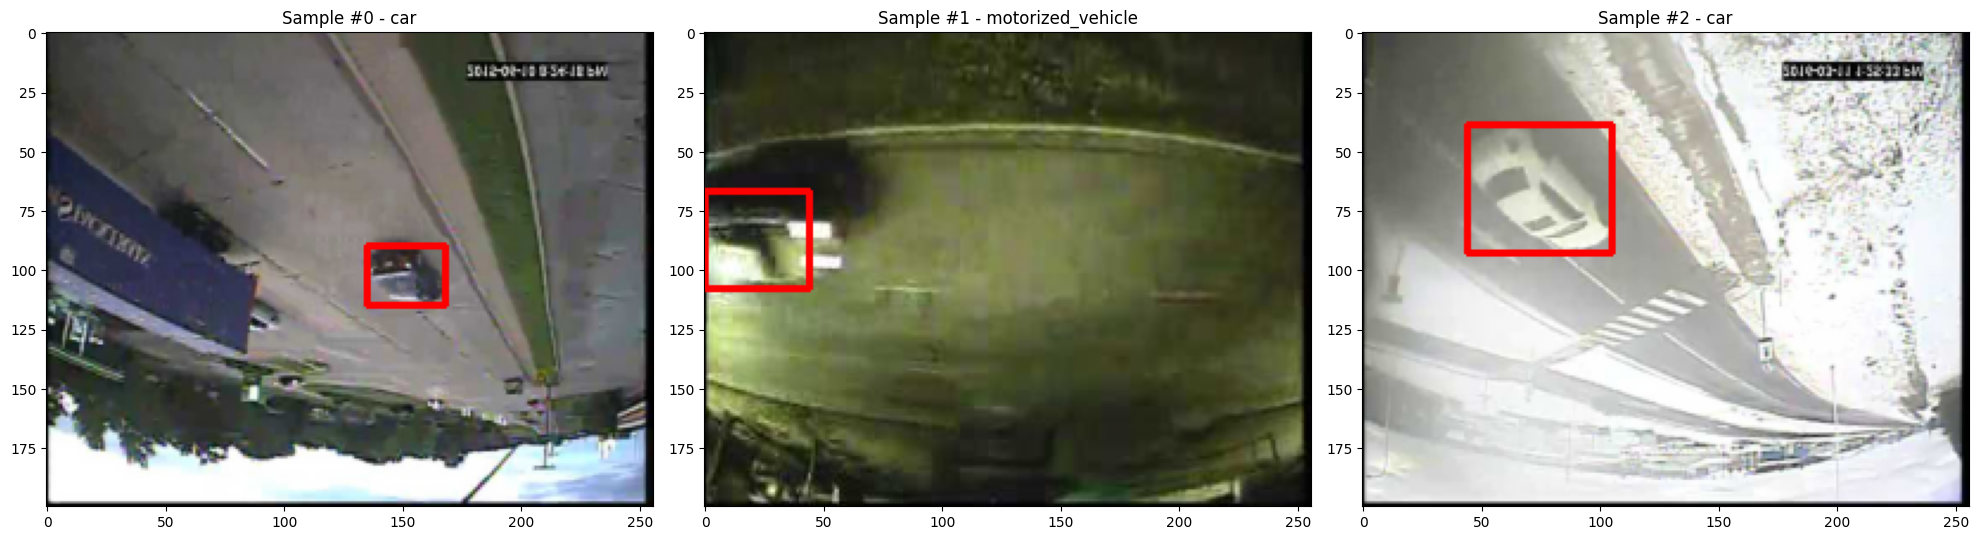

In [19]:
local_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/localize'
cls_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/classification'

task_type = "localization"
class_name='work_van'
compose_transforms = transforms.Compose([Rescale(output_size=(200, 256), task_type = "localization"),
                                         Flip(flip_type=1, task_type = "localization")
                                         ])

local_data = CustomDataloader(local_dir, cls_dir, task_type, class_name)
local_visualize(local_data)

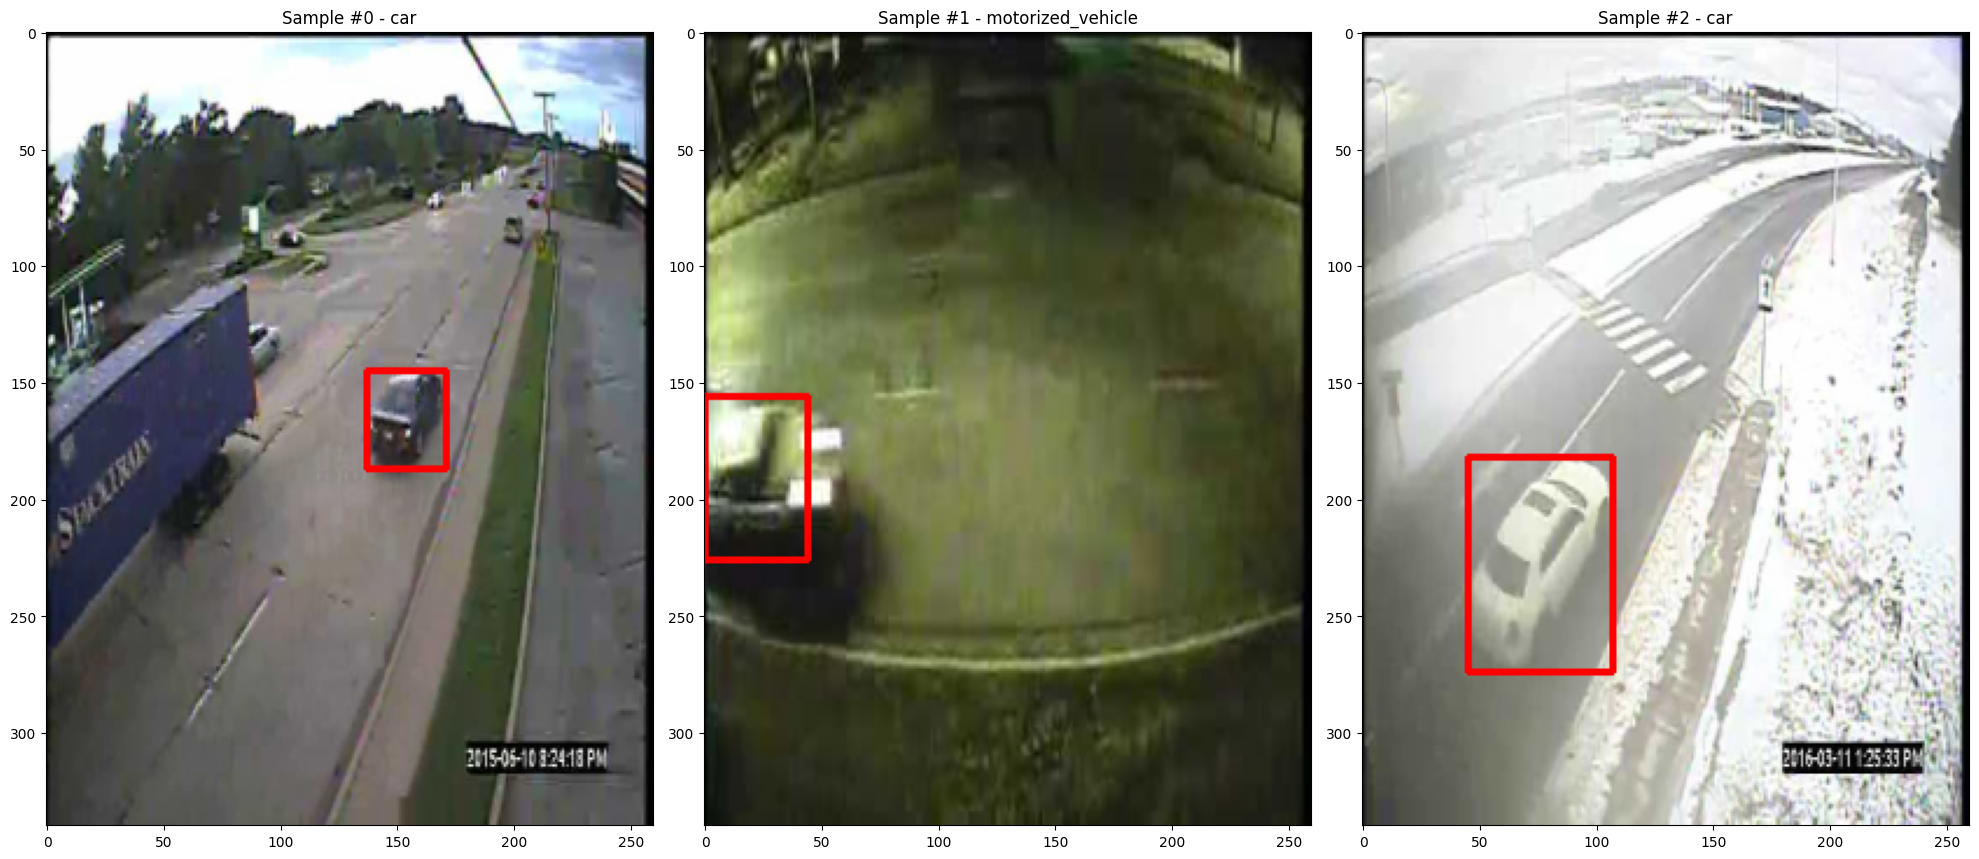

In [20]:
local_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/localize'
cls_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/classification'

task_type = "localization"

compose_transforms = transforms.Compose([Rescale(output_size=(340, 260), task_type = "localization"),
                                         Flip(flip_type=0,task_type = "localization"),
                                        #  ToTensor(),
                                        #  Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
                                        ])
fig = plt.figure(figsize=(20, 20))
ncols = 3
local_data = CustomDataloader(local_dir, cls_dir, task_type, class_name, transform=compose_transforms)
local_visualize(local_data)

In [11]:
local_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/localize'
cls_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/classification'

task_type = "localization"
from torchvision import transforms

compose_transforms = transforms.Compose([Rescale(output_size=(340, 260), task_type = "localization"),
                                         Flip(flip_type=0,task_type = "localization"),
                                         ToTensor(),
                                        #  Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
                                        ])
cls_data = CustomDataloader(local_dir, cls_dir, task_type, transform=compose_transforms)
selected_cls_image = cls_data[31]
selected_cls_image

<class 'numpy.ndarray'>
torch.Size([340, 260, 3]) torch.Size([3, 340, 260])


{'image': tensor([[[0.0555, 0.1676, 0.6746,  ..., 0.0845, 0.1279, 0.0137],
          [0.0555, 0.1676, 0.6746,  ..., 0.5731, 0.3668, 0.0248],
          [0.0555, 0.1676, 0.6746,  ..., 0.7078, 0.4279, 0.0188],
          ...,
          [0.0407, 0.0784, 0.2622,  ..., 0.3423, 0.2323, 0.0302],
          [0.0407, 0.0784, 0.2629,  ..., 0.3423, 0.2323, 0.0302],
          [0.0407, 0.0784, 0.2636,  ..., 0.3423, 0.2323, 0.0302]],
 
         [[0.0554, 0.1642, 0.6688,  ..., 0.1042, 0.1549, 0.0411],
          [0.0554, 0.1642, 0.6688,  ..., 0.6006, 0.3925, 0.0420],
          [0.0554, 0.1642, 0.6688,  ..., 0.7353, 0.4526, 0.0297],
          ...,
          [0.0211, 0.0611, 0.2498,  ..., 0.3463, 0.2362, 0.0342],
          [0.0211, 0.0611, 0.2505,  ..., 0.3463, 0.2362, 0.0342],
          [0.0211, 0.0611, 0.2513,  ..., 0.3463, 0.2362, 0.0342]],
 
         [[0.0578, 0.1846, 0.7099,  ..., 0.1434, 0.1941, 0.0804],
          [0.0578, 0.1846, 0.7099,  ..., 0.6398, 0.4318, 0.0812],
          [0.0578, 0.1846, 0.70

In [12]:
local_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/localize'
cls_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/classification'

task_type = "localization"
from torchvision import transforms

compose_transforms = transforms.Compose([Rescale(output_size=(340, 260), task_type = "localization"),
                                         Flip(flip_type=0,task_type = "localization"),
                                         ToTensor(),
                                         Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
                                        ])
cls_data = CustomDataloader(local_dir, cls_dir, task_type, transform=compose_transforms)
selected_cls_image = cls_data[31]
selected_cls_image

<class 'numpy.ndarray'>
torch.Size([340, 260, 3]) torch.Size([3, 340, 260])


{'image': tensor([[[-0.8889, -0.6647,  0.3493,  ..., -0.8311, -0.7442, -0.9726],
          [-0.8889, -0.6647,  0.3493,  ...,  0.1463, -0.2664, -0.9505],
          [-0.8889, -0.6647,  0.3493,  ...,  0.4156, -0.1443, -0.9624],
          ...,
          [-0.9185, -0.8432, -0.4757,  ..., -0.3153, -0.5355, -0.9395],
          [-0.9185, -0.8432, -0.4742,  ..., -0.3153, -0.5355, -0.9395],
          [-0.9185, -0.8432, -0.4727,  ..., -0.3153, -0.5355, -0.9395]],
 
         [[-0.8892, -0.6717,  0.3376,  ..., -0.7916, -0.6901, -0.9177],
          [-0.8892, -0.6717,  0.3376,  ...,  0.2012, -0.2149, -0.9160],
          [-0.8892, -0.6717,  0.3376,  ...,  0.4705, -0.0949, -0.9405],
          ...,
          [-0.9578, -0.8777, -0.5005,  ..., -0.3075, -0.5276, -0.9317],
          [-0.9578, -0.8777, -0.4990,  ..., -0.3075, -0.5276, -0.9317],
          [-0.9578, -0.8777, -0.4975,  ..., -0.3075, -0.5276, -0.9317]],
 
         [[-0.8845, -0.6309,  0.4198,  ..., -0.7132, -0.6117, -0.8393],
          [-0.8845,

**EXAMPLE USE**

In [13]:
##example use of zfill

txt = "50"

x = txt.zfill(10) #prepends a number of zeros to a string to get the specified string length

print(x)



0000000050


In [14]:
##example use of zfill

img = "1250"

img = txt.zfill(5)

print(img)

00050


In [16]:
#example use of cv2.rectangle

# This uses the open cv library to draw a rectangle of a specific color and thickness
# as used in the code above the choosen color (255, 0, 0) is red because 255 is in the red part of the RGB
# the chosen thickness is 2 pixels and the (x,y) from the bounding box coordinates are the starting point and the (w,h) is the endpoint.

#image = cv2.rectangle(image, start_point, end_point, color, thickness)

#img=cv2.rectangle(image, (x, y), (w, h), (255, 0, 0), 2)

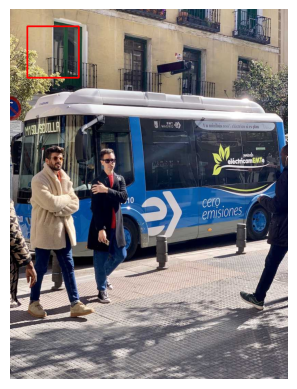

In [17]:
import cv2

img = cv2.imread("bus.jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#cv2 changes channel to BGR so have to change it back to RGB
start_point = (50, 50)
end_point = (200, 200)
color = (255, 0, 0)
thickness = 3
image = cv2.rectangle(img, start_point, end_point, color, thickness)
plt.imshow(image)
plt.axis('off')
plt.show()

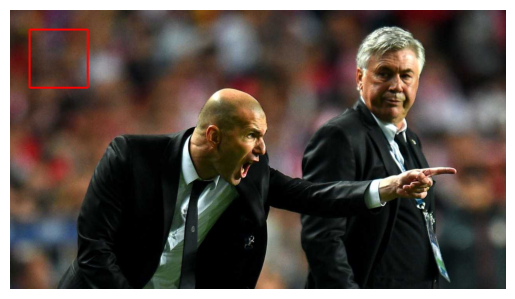

In [18]:
import cv2

img = cv2.imread("zidane.jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#cv2 changes channel to BGR so have to change it back to RGB
start_point = (50, 50)
end_point = (200, 200)
color = (255, 0, 0)
thickness = 3
image = cv2.rectangle(img, start_point, end_point, color, thickness)
plt.imshow(image)
plt.axis('off')
plt.show()